In [111]:
import pandas as pd
import datetime as time
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

# Predicting the result based on the Probability Distribution

In [150]:
season = ['2012','2013','2014','2015','2016']

home_json_data = {}
away_json_data = {}

def generatecompletedata(season):
    df = pd.read_csv('premier-league-' + season + '.csv')
    pl_games = df[(df['league'] == 'Premier League')]
    pl_games = pl_games.reset_index(drop=True)
    # 1. read raw data from csv file, organize the data
    for index, row in pl_games.iterrows():
        homeTeam = str(row['home'])
        awayTeam = str(row['away'])
        home_goals = int(row['home_goals'])
        away_goals = int(row['away_goals'])
        if homeTeam in home_json_data:
            home_json_data[homeTeam]['games_played'] += 1
            home_json_data[homeTeam]['goals_for'] += home_goals
            home_json_data[homeTeam]['goals_against'] += away_goals
        else:
            home_json_data[homeTeam] = {}
            home_json_data[homeTeam]['games_played'] = 1
            home_json_data[homeTeam]['goals_for'] = home_goals
            home_json_data[homeTeam]['goals_against'] = away_goals

        if awayTeam in away_json_data:
            away_json_data[awayTeam]['games_played'] += 1
            away_json_data[awayTeam]['goals_for'] += away_goals
            away_json_data[awayTeam]['goals_against'] += home_goals
        else:
            away_json_data[awayTeam] = {}
            away_json_data[awayTeam]['games_played'] = 1
            away_json_data[awayTeam]['goals_for'] = away_goals
            away_json_data[awayTeam]['goals_against'] = home_goals


for s in season:
    generatecompletedata(s)

home_total_game_count = 0
home_total_goals_for = 0
home_total_goals_against = 0
home_average_goals_for = 0
home_average_goals_against = 0

away_total_game_count = 0
away_total_goals_for = 0
away_total_goals_against = 0
away_average_goals_for = 0
away_average_goals_against = 0

# 2. get basic stats of home and away data
for team in home_json_data.keys():
    average_goals_for = float(home_json_data[team]['goals_for']) / float(home_json_data[team]['games_played'])
    average_goals_against = float(home_json_data[team]['goals_against']) / float(home_json_data[team]['games_played'])

    home_json_data[team]['average_goals_for'] = average_goals_for
    home_json_data[team]['average_goals_against'] = average_goals_against

    home_total_game_count += home_json_data[team]['games_played']
    home_total_goals_for += home_json_data[team]['goals_for']
    home_total_goals_against += home_json_data[team]['goals_against']
    home_average_goals_against += home_json_data[team]['average_goals_for']
    home_average_goals_for += home_json_data[team]['average_goals_against']

all_teams = list(home_json_data.keys())
home_team_counts = len(all_teams)
home_json_data['total'] = {'games_played': home_total_game_count,
                           'goals_for': home_total_goals_for,
                           'average_goals_for': home_average_goals_for,
                           'goals_against': home_average_goals_against,
                           'average_goals_against': home_average_goals_against}

home_json_data['average'] = {'games_played': home_total_game_count / home_team_counts,
                           'goals_for': home_total_goals_for / float(home_team_counts),
                           'average_goals_for': home_average_goals_for / float(home_team_counts),
                           'goals_against': home_average_goals_against / float(home_team_counts),
                           'average_goals_against': home_average_goals_against / float(home_team_counts)}


for team in away_json_data.keys():
    average_goals_for = float(away_json_data[team]['goals_for']) / float(away_json_data[team]['games_played'])
    average_goals_against = float(away_json_data[team]['goals_against']) / float(away_json_data[team]['games_played'])

    away_json_data[team]['average_goals_for'] = average_goals_for
    away_json_data[team]['average_goals_against'] = average_goals_against

    away_total_game_count += away_json_data[team]['games_played']
    away_total_goals_for += away_json_data[team]['goals_for']
    away_total_goals_against += away_json_data[team]['goals_against']
    away_average_goals_against += away_json_data[team]['average_goals_for']
    away_average_goals_for += away_json_data[team]['average_goals_against']

away_team_counts = len(all_teams)
away_json_data['total'] = {'games_played': away_total_game_count,
                           'goals_for': away_total_goals_for,
                           'average_goals_for': away_average_goals_for,
                           'goals_against': away_average_goals_against,
                           'average_goals_against': away_average_goals_against}

away_json_data['average'] = {'games_played': away_total_game_count / away_team_counts,
                           'goals_for': away_total_goals_for / float(away_team_counts),
                           'average_goals_for': away_average_goals_for / float(away_team_counts),
                           'goals_against': away_average_goals_against / float(away_team_counts),
                           'average_goals_against': away_average_goals_against / float(away_team_counts)}

home_df = pd.DataFrame(home_json_data).T
away_df = pd.DataFrame(away_json_data).T

# 3. calculate attack and defense strength
strength_json = {}
home_average_attacking_strength = 0.0
home_average_defensive_strength = 0.0
away_average_attacking_strength = 0.0
away_average_defensive_strength = 0.0

for team in all_teams:
    strength_json[team] = {}
    home_attacking_strength = home_json_data[team]['average_goals_for'] / home_json_data['average']['average_goals_for']
    home_defensive_strength = home_json_data[team]['average_goals_against'] / home_json_data['average']['average_goals_against']
    away_attacking_strength = away_json_data[team]['average_goals_for'] / away_json_data['average']['average_goals_for']
    away_defensive_strength = away_json_data[team]['average_goals_against'] / away_json_data['average']['average_goals_against']
    strength_json[team]['home_attacking_strength'] = home_attacking_strength
    strength_json[team]['home_defensive_strength'] = home_defensive_strength
    strength_json[team]['away_attacking_strength'] = away_attacking_strength
    strength_json[team]['away_defensive_strength'] = away_defensive_strength

    home_average_attacking_strength += home_attacking_strength
    home_average_defensive_strength += home_defensive_strength
    away_average_attacking_strength += away_attacking_strength
    away_average_defensive_strength += away_defensive_strength


home_average_attacking_strength /= float(len(all_teams))
home_average_defensive_strength /= float(len(all_teams))
away_average_attacking_strength /= float(len(all_teams))
away_average_defensive_strength /= float(len(all_teams))

strength_json['average'] = {'home_attacking_strength': home_attacking_strength,
                            'home_defensive_strength': home_defensive_strength,
                            'away_attacking_strength': away_average_attacking_strength,
                            'away_defensive_strength': away_average_defensive_strength}

strength_df = pd.DataFrame(strength_json).T

# 4. goal expectancy
# calculate how many goals we expect a team to score in a particular match - we call this the Goal Expectancy
# Home Team Goal Expectancy: home attacking strength x away defensive strength x average goals home
# Away Team Goal Expectancy: away attacking strength x home defensive strength x average goals away
def get_goal_expectancy(homeTeam, awayTeam):
    global home_json_data, away_json_data, strength_json
    if homeTeam not in home_json_data.keys():
        home_team_goal_expectancy = strength_json['average']['home_attacking_strength'] \
                                    * strength_json[awayTeam]['away_defensive_strength'] \
                                    * home_json_data['average']['average_goals_for']

        away_team_goal_expectancy = strength_json[awayTeam]['away_attacking_strength'] \
                                    * strength_json['average']['home_defensive_strength'] \
                                    * away_json_data['average']['average_goals_for']

    elif awayTeam not in away_json_data.keys():
        home_team_goal_expectancy = strength_json[homeTeam]['home_attacking_strength'] \
                                    * strength_json['average']['away_defensive_strength'] \
                                    * home_json_data['average']['average_goals_for']

        away_team_goal_expectancy = strength_json['average']['away_attacking_strength'] \
                                    * strength_json[homeTeam]['home_defensive_strength'] \
                                    * away_json_data['average']['average_goals_for']

    else:
        home_team_goal_expectancy = strength_json[homeTeam]['home_attacking_strength'] \
                                    * strength_json[awayTeam]['away_defensive_strength'] \
                                    * home_json_data['average']['average_goals_for']

        away_team_goal_expectancy = strength_json[awayTeam]['away_attacking_strength'] \
                                    * strength_json[homeTeam]['home_defensive_strength'] \
                                    * away_json_data['average']['average_goals_for']

    return (home_team_goal_expectancy, away_team_goal_expectancy)

#print get_goal_expectancy('Arsenal', 'Chelsea')

# 5. calculate poisson distribution
from scipy.stats import poisson
# poisson.pmf(x, mu)
def get_poisson_distribution(homeTeam, awayTeam):
    goal_home_size = 11
    goal_away_size = 11
    # from 0-0 to 10-10
    poisson_distribution_json = {}
    for home_goal_count in range(goal_home_size):
        current_row = {}
        for away_goal_count in range(goal_away_size):
            home_expectancy, away_expectancy = get_goal_expectancy(awayTeam, homeTeam)
            home_poisson_value = poisson.pmf(home_goal_count, home_expectancy)
            away_poisson_value = poisson.pmf(away_goal_count, away_expectancy)
            current_row[away_goal_count] = home_poisson_value * away_poisson_value * 100

        poisson_distribution_json[home_goal_count] = current_row

    return poisson_distribution_json

poisson_json = get_poisson_distribution('Arsenal', 'Chelsea')
poisson_df = pd.DataFrame(poisson_json).T

# 6. get_winning_rate_from_poisson_distribution
def get_winning_rate_from_poisson_distribution(homeTeam, awayTeam):
    poisson_json = get_poisson_distribution(homeTeam, awayTeam)
    home_win_probability = 0.0
    draw_probability = 0.0
    away_win_probability = 0.0

    for home_goal_count in poisson_json.keys():
        current_row = poisson_json[home_goal_count]
        for away_goal_count in current_row.keys():
            if home_goal_count < away_goal_count:
                away_win_probability += current_row[away_goal_count]
            elif home_goal_count == away_goal_count:
                draw_probability += current_row[away_goal_count]
            else:
                home_win_probability += current_row[away_goal_count]


    return {'home_win': {'probability': '{0}%'.format(home_win_probability)},
            'draw': {'probability': '{0}%'.format(draw_probability)},
            'away_win': {'probability': '{0}%'.format(away_win_probability)}}


#print get_winning_rate_from_poisson_distribution('Chelsea', 'Liverpool')

# 7. Now predict the result for the games for 2017 based on goal expectancy
test_season = '2017'
df = pd.read_csv('premier-league-' + test_season + '.csv')
pl_games = df[(df['league'] == 'Premier League')]
pl_games = pl_games.reset_index(drop=True)
results = {}
outcome = None
for index, row in pl_games.iterrows():
    homeTeam = str(row['home'])
    awayTeam = str(row['away'])
    actual_outcome = str(row['result'])
    hwr, awr = get_goal_expectancy(homeTeam, awayTeam)
    if hwr > awr:
        outcome = 'W'
    elif hwr < awr:
        outcome = 'L'
    else:
        outcome = 'D'

    results[index] = {'home': homeTeam, 'away': awayTeam, 'result_actual': actual_outcome, 'result_observed': outcome}
results_df = pd.DataFrame(results).T

# 8. Now compare the results with that of the actual data we have from 2017 season
count = 0
for i, row in results_df.iterrows():
    if str(row['result_observed']) == str(row['result_actual']):
        count += 1
accuracy = (count)/float(len(results_df.index))
print("count = " + str(count))
print("accuracy = " + str(accuracy))

count = 106
accuracy = 0.4818181818181818


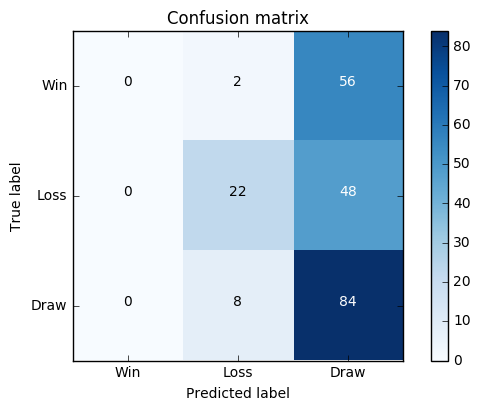

In [158]:
class_names = ['Win', 'Loss', 'Draw']
y_pred = list(results_df['result_observed'])
y_test = list(results_df['result_actual'])
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print()

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
#np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')

# # Plot normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')

plt.show()

## Data Preparation for ML Models

In [60]:
#season = ['0001', '0102','0203','0304', '0405', '0506', '0607', '0708', '0809', '0910','1011', '1112', '1213', '1314', '1415', '1516']
season = ['0506', '0607', '0708', '0809', '0910','1011', '1112', '1213', '1314', '1415', '1516']
dataframe = pd.DataFrame()
list_ = []
for s in season:
    df = pd.read_csv('epl' + s + '.csv')
    col = ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'Referee', 'HST', 'AST', 'HC', 'AC', 'HR', 'AR']
    df_temp = df[col]
    df_temp = df_temp
    list_.append(df_temp)
dataframe = pd.concat(list_)
dataframe.loc[dataframe['FTR'] == 'A','FTR'] = 0
dataframe.loc[dataframe['FTR'] == 'D','FTR'] = 1
dataframe.loc[dataframe['FTR'] == 'H','FTR'] = 2
dataframe['FTR'] = dataframe['FTR'].apply(lambda x:float(x))
dataframe = dataframe.dropna()
#dataframe

In [85]:
dataframe

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Referee,HST,AST,HC,...,H2H6FTHGS,H2H6FTAGS,H2H6FTHGC,H2H6FTAGC,H2H6HST,H2H6AST,H2H6HC,H2H6AC,H2H6HR,H2H6AR
0,13/08/05,Aston Villa,Bolton,2.0,2.0,1.0,M Riley,2.0,6.0,7.0,...,17.0,9.0,9.0,17.0,49.0,44.0,55.0,28.0,0.0,0.0
1,13/08/05,Everton,Man United,0.0,2.0,0.0,G Poll,5.0,5.0,8.0,...,15.0,16.0,16.0,15.0,73.0,78.0,59.0,71.0,0.0,0.0
2,13/08/05,Fulham,Birmingham,0.0,0.0,1.0,R Styles,7.0,4.0,6.0,...,5.0,2.0,2.0,5.0,26.0,13.0,18.0,19.0,0.0,0.0
3,13/08/05,Man City,West Brom,0.0,0.0,1.0,C Foy,8.0,3.0,3.0,...,20.0,4.0,4.0,20.0,75.0,46.0,51.0,45.0,0.0,1.0
4,13/08/05,Middlesbrough,Liverpool,0.0,0.0,1.0,M Halsey,2.0,7.0,5.0,...,3.0,1.0,1.0,3.0,9.0,31.0,12.0,30.0,1.0,0.0
5,13/08/05,Portsmouth,Tottenham,0.0,2.0,0.0,B Knight,7.0,6.0,7.0,...,4.0,6.0,6.0,4.0,40.0,30.0,34.0,27.0,2.0,1.0
6,13/08/05,Sunderland,Charlton,1.0,3.0,0.0,H Webb,8.0,4.0,5.0,...,1.0,3.0,3.0,1.0,8.0,4.0,5.0,5.0,0.0,1.0
7,13/08/05,West Ham,Blackburn,3.0,1.0,2.0,A Wiley,5.0,5.0,2.0,...,12.0,5.0,5.0,12.0,43.0,32.0,42.0,38.0,0.0,1.0
8,14/08/05,Arsenal,Newcastle,2.0,0.0,2.0,S Bennett,12.0,1.0,8.0,...,26.0,7.0,7.0,26.0,88.0,33.0,88.0,28.0,1.0,1.0
9,14/08/05,Wigan,Chelsea,0.0,1.0,0.0,M Clattenburg,5.0,9.0,2.0,...,6.0,17.0,17.0,6.0,52.0,48.0,34.0,35.0,0.0,1.0


# Correlation Values 

In [86]:
dataframe.corr()

,FTHG,FTAG,FTR,HST,AST,HC,AC,HR,AR,6HW,...,H2H6FTHGS,H2H6FTAGS,H2H6FTHGC,H2H6FTAGC,H2H6HST,H2H6AST,H2H6HC,H2H6AC,H2H6HR,H2H6AR
FTHG,1.000000,-0.057876,0.616593,0.395914,-0.088069,0.025066,-0.074813,-0.088040,0.088242,NaN,...,0.235268,-0.110659,-0.110659,0.235268,0.115086,-0.100482,0.060431,-0.095562,-0.065220,0.007590
FTAG,-0.057876,1.000000,-0.631446,-0.089349,0.414227,-0.052890,0.030713,0.117891,-0.079385,NaN,...,-0.116429,0.214041,0.214041,-0.116429,-0.095098,0.085833,-0.088864,0.036611,0.023633,-0.025516
FTR,0.616593,-0.631446,1.000000,0.279217,-0.286080,0.027220,-0.037010,-0.145172,0.108716,NaN,...,0.215327,-0.205938,-0.205938,0.215327,0.128189,-0.120252,0.085223,-0.078778,-0.056777,0.039044
HST,0.395914,-0.089349,0.279217,1.000000,-0.048276,0.365236,-0.178820,-0.090966,0.067597,NaN,...,0.206442,-0.122271,-0.122271,0.206442,0.248204,-0.083320,0.146767,-0.085639,-0.056589,0.023738
AST,-0.088069,0.414227,-0.286080,-0.048276,1.000000,-0.182247,0.359975,0.089739,-0.099619,NaN,...,-0.116738,0.169250,0.169250,-0.116738,-0.080856,0.214852,-0.089714,0.122058,0.046066,-0.024034
HC,0.025066,-0.052890,0.027220,0.365236,-0.182247,1.000000,-0.227209,-0.066846,0.033954,NaN,...,0.083447,-0.136799,-0.136799,0.083447,0.094933,-0.122860,0.138275,-0.111995,-0.080104,-0.005375
AC,-0.074813,0.030713,-0.037010,-0.178820,0.359975,-0.227209,1.000000,0.071493,-0.068279,NaN,...,-0.096533,0.063561,0.063561,-0.096533,-0.096307,0.086235,-0.093553,0.168347,0.020417,-0.033541
HR,-0.088040,0.117891,-0.145172,-0.090966,0.089739,-0.066846,0.071493,1.000000,0.061091,NaN,...,-0.032750,0.032800,0.032800,-0.032750,-0.009737,0.030351,-0.019184,0.030155,0.284370,0.029309
AR,0.088242,-0.079385,0.108716,0.067597,-0.099619,0.033954,-0.068279,0.061091,1.000000,NaN,...,0.029219,0.009536,0.009536,0.029219,0.026397,0.006780,0.017578,0.009593,0.045908,0.262891
6HW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Utilities For feature extraction

In [62]:
#method to get last x matches
def get_lastmatches_data(dataframe, date1, team, x=6):
    prev_matches = dataframe[(dataframe['HomeTeam'] == team) | (dataframe['AwayTeam'] == team)]
    prev_matches = prev_matches.reset_index(drop=True)
    i = 0
    # get the last x games
    index1 = prev_matches.shape[0]
    for index, row in prev_matches.iterrows():
        date = str(row['Date'])
        if time.datetime.strptime(date, "%d/%m/%y") \
                < time.datetime.strptime(date1, "%d/%m/%y"):
            continue
        else:
            index1 = index
            break
    df_temp = prev_matches.iloc[index1 - 6:index1]
    return df_temp

#method to get last x matches
def get_lastmatchesH2H_data(dataframe, date1, hometeam, awayteam, x=6):
   prev_matches = dataframe[(dataframe['HomeTeam'] == hometeam) & (dataframe['AwayTeam'] == awayteam) \
      | (dataframe['AwayTeam'] == hometeam) & (dataframe['HomeTeam'] == awayteam)]
   prev_matches = prev_matches.reset_index(drop=True)
   # get the last x games
   index1 = prev_matches.shape[0]
   for index, row in prev_matches.iterrows():
       date = str(row['Date'])
       if time.datetime.strptime(date, "%d/%m/%y") \
               < time.datetime.strptime(date1, "%d/%m/%y"):
           continue
       else:
           index1 = index
           break
   if index1 - 6 >= 0:
       df_temp = prev_matches.iloc[index1 - 6:index1]
   else:
       df_temp = prev_matches.iloc[0:prev_matches.shape[0]]
   return df_temp


# helper functions
def get_number_of_losses(matches, date, team, x=6):
    last_matches_df = get_lastmatches_data(matches, date, team, x)
    count = 0
    for _, row in last_matches_df.iterrows():
        # if team is home team
        if row['HomeTeam'] == team:
            if row['FTR'] == 'A':
                count += 1
        else:
            # team is away team
            if row['FTR'] == 'H':
                count += 1
    return count


def get_number_of_draws(matches, date, team, x=6):
    last_matches_df = get_lastmatches_data(matches, date, team, x)
    count = 0
    for _, row in last_matches_df.iterrows():
        if row['FTR'] == 'D':
            count += 1
    return count


def get_number_of_wins(matches, date, team, x=6):
    last_matches_df = get_lastmatches_data(matches, date, team, x)
    count = 0
    for _, row in last_matches_df.iterrows():
        # if team is home team
        if row['HomeTeam'] == team:
            if row['FTR'] == 'H':
                count += 1
        else:
            # team is away team
            if row['FTR'] == 'A':
                count += 1
    return count

def get_number_of_h2h_losses(matches, date, home_team, away_team, target_team, x=6):
    last_matches_df = get_lastmatchesH2H_data(matches, date, home_team, away_team, x)
    count = 0
    for _, row in last_matches_df.iterrows():
        # if team is home team
        if row['HomeTeam'] == target_team:
            if row['FTR'] == 'A':
                count += 1
        else:
            # team is away team
            if row['FTR'] == 'H':
                count += 1
    return count


def get_number_of_h2h_draws(matches, date, home_team, away_team, target_team=None, x=6):
    last_matches_df = get_lastmatchesH2H_data(matches, date, home_team, away_team, x)
    count = 0
    for _, row in last_matches_df.iterrows():
        if row['FTR'] == 'D':
            count += 1
    return count

def get_number_of_h2h_wins(matches, date, home_team, away_team, target_team, x=6):
    last_matches_df = get_lastmatchesH2H_data(matches, date, home_team, away_team, x)
    count = 0
    for _, row in last_matches_df.iterrows():
        # if team is home team
        if row['HomeTeam'] == target_team:
            if row['FTR'] == 'H':
                count += 1
        else:
            # team is away team
            if row['FTR'] == 'A':
                count += 1
    return count


def get_number_of_goals_scored(matches, date, team, x=6):
    last_matches_df = get_lastmatches_data(matches, date, team, x)
    count = 0
    for _, row in last_matches_df.iterrows():
        # if team is home team
        if row['HomeTeam'] == team:
            count += row['FTHG']
        else:
            # team is away team
            count += row['FTAG']
    return count


def get_number_of_goals_conceded(matches, date, team, x=6):
    last_matches_df = get_lastmatches_data(matches, date, team, x)
    count = 0
    for _, row in last_matches_df.iterrows():
        # if team is home team
        if row['HomeTeam'] == team:
            count += row['FTAG']
        else:
            # team is away team
            count += row['FTHG']
    return count


def get_number_of_shots_on_target(matches, date, team, x=6):
    last_matches_df = get_lastmatches_data(matches, date, team, x)
    count = 0
    for _, row in last_matches_df.iterrows():
        # if team is home team
        if row['HomeTeam'] == team:
            count += row['HST']
        else:
            # team is away team
            count += row['AST']
    return count


def get_number_of_corners(matches, date, team, x=6):
    last_matches_df = get_lastmatches_data(matches, date, team, x)
    count = 0
    for _, row in last_matches_df.iterrows():
        # if team is home team
        if row['HomeTeam'] == team:
            count += row['HC']
        else:
            # team is away team
            count += row['AC']
    return count


def get_number_of_red_cards(matches, date, team, x=6):
    last_matches_df = get_lastmatches_data(matches, date, team, x)
    count = 0
    for _, row in last_matches_df.iterrows():
        # if team is home team
        if row['HomeTeam'] == team:
            count += row['HR']
        else:
            # team is away team
            count += row['AR']
    return count


def get_number_of_h2h_home_goals_scored(matches, date, home_team, away_team, target_team, x=6):
    last_matches_df = get_lastmatchesH2H_data(matches, date, home_team, away_team, x)
    count = 0
    for _, row in last_matches_df.iterrows():
        # if team is home team
        if row['HomeTeam'] == target_team:
            count += row['FTHG']
    return count


def get_number_of_h2h_home_goals_conceded(matches, date, home_team, away_team, target_team, x=6):
    last_matches_df = get_lastmatchesH2H_data(matches, date, home_team, away_team, x)
    count = 0
    for _, row in last_matches_df.iterrows():
        # if team is home team
        if row['HomeTeam'] == target_team:
            count += row['FTAG']
    return count


def get_number_of_h2h_away_goals_scored(matches, date, home_team, away_team, target_team, x=6):
    last_matches_df = get_lastmatchesH2H_data(matches, date, home_team, away_team, x)
    count = 0
    for _, row in last_matches_df.iterrows():
        # if team is away team
        if row['AwayTeam'] == target_team:
            count += row['FTAG']
    return count


def get_number_of_h2h_away_goals_conceded(matches, date, home_team, away_team, target_team, x=6):
    last_matches_df = get_lastmatchesH2H_data(matches, date, home_team, away_team, x)
    count = 0
    for _, row in last_matches_df.iterrows():
        # if team is away team
        if row['AwayTeam'] == target_team:
            count += row['FTHG']
    return count


def get_number_of_h2h_home_shot_on_target(matches, date, home_team, away_team, target_team, x=6):
    last_matches_df = get_lastmatchesH2H_data(matches, date, home_team, away_team, x)
    count = 0
    for _, row in last_matches_df.iterrows():
        # if team is home team
        if row['HomeTeam'] == target_team:
            count += row['HST']
    return count


def get_number_of_h2h_away_shot_on_target(matches, date, home_team, away_team, target_team, x=6):
    last_matches_df = get_lastmatchesH2H_data(matches, date, home_team, away_team, x)
    count = 0
    for _, row in last_matches_df.iterrows():
        # if team is away team
        if row['AwayTeam'] == target_team:
            count += row['AST']
    return count


def get_number_of_h2h_home_corners(matches, date, home_team, away_team, target_team, x=6):
    last_matches_df = get_lastmatchesH2H_data(matches, date, home_team, away_team, x)
    count = 0
    for _, row in last_matches_df.iterrows():
        # if team is home team
        if row['HomeTeam'] == target_team:
            count += row['HC']
    return count


def get_number_of_h2h_away_corners(matches, date, home_team, away_team, target_team, x=6):
    last_matches_df = get_lastmatchesH2H_data(matches, date, home_team, away_team, x)
    count = 0
    for _, row in last_matches_df.iterrows():
        # if team is away team
        if row['AwayTeam'] == target_team:
            count += row['AC']
    return count


def get_number_of_h2h_home_red_cards(matches, date, home_team, away_team, target_team, x=6):
    last_matches_df = get_lastmatchesH2H_data(matches, date, home_team, away_team, x)
    count = 0
    for _, row in last_matches_df.iterrows():
        # if team is home team
        if row['HomeTeam'] == target_team:
            count += row['HR']
    return count


def get_number_of_h2h_away_red_cards(matches, date, home_team, away_team, target_team, x=6):
    last_matches_df = get_lastmatchesH2H_data(matches, date, home_team, away_team, x)
    count = 0
    for _, row in last_matches_df.iterrows():
        # if team is away team
        if row['AwayTeam'] == target_team:
            count += row['AR']
    return count

# Preparing the holistic Features Table

In [63]:
_6HW = []
_6HL = []
_6AW = []
_6AL = []
_6FTHGS = []
_6FTHGC = []
_6FTAGS = []
_6FTAGC = []
_6HST = []
_6AST = []
_6HC = []
_6AC = []
_6HR = []
_6AR = []
_H2H6FTHGS = []
_H2H6FTAGS = []
_H2H6FTHGC = []
_H2H6FTAGC = []
_H2H6HST = []
_H2H6AST = []
_H2H6HC = []
_H2H6AC = []
_H2H6HR = []
_H2H6AR = []
_6HD = []
_6AD = []

# building the final data frame
for _,row in dataframe.iterrows():
    _6HW.append(get_number_of_wins(dataframe, str(row['Date']), str(row['HomeTeam'])))
    _6AW.append(get_number_of_wins(dataframe, str(row['Date']), str(row['AwayTeam'])))
    _6HD.append(get_number_of_draws(dataframe, str(row['Date']), str(row['HomeTeam'])))
    _6AD.append(get_number_of_draws(dataframe, str(row['Date']), str(row['AwayTeam'])))
    _6HL.append(get_number_of_losses(dataframe, str(row['Date']), str(row['HomeTeam'])))
    _6AL.append(get_number_of_losses(dataframe, str(row['Date']), str(row['AwayTeam'])))
    _6FTHGS.append(get_number_of_goals_scored(dataframe, str(row['Date']), str(row['HomeTeam'])))
    _6FTHGC.append(get_number_of_goals_conceded(dataframe, str(row['Date']), str(row['HomeTeam'])))
    _6FTAGS.append(get_number_of_goals_scored(dataframe, str(row['Date']), str(row['AwayTeam'])))
    _6FTAGC.append(get_number_of_goals_conceded(dataframe, str(row['Date']), str(row['AwayTeam'])))
    _6HST.append(get_number_of_shots_on_target(dataframe, str(row['Date']), str(row['HomeTeam'])))
    _6AST.append(get_number_of_shots_on_target(dataframe, str(row['Date']), str(row['AwayTeam'])))
    _6HC.append(get_number_of_corners(dataframe, str(row['Date']), str(row['HomeTeam'])))
    _6AC.append(get_number_of_corners(dataframe, str(row['Date']), str(row['AwayTeam'])))
    _6HR.append(get_number_of_red_cards(dataframe, str(row['Date']), str(row['HomeTeam'])))
    _6AR.append(get_number_of_red_cards(dataframe, str(row['Date']), str(row['AwayTeam'])))
    _H2H6FTHGS.append(get_number_of_h2h_home_goals_scored(dataframe, str(row['Date']), str(row['HomeTeam']), str(row['AwayTeam']), str(row['HomeTeam'])))
    _H2H6FTAGS.append(get_number_of_h2h_away_goals_scored(dataframe, str(row['Date']), str(row['HomeTeam']), str(row['AwayTeam']), str(row['AwayTeam'])))
    _H2H6FTHGC.append(get_number_of_h2h_home_goals_conceded(dataframe, str(row['Date']), str(row['HomeTeam']), str(row['AwayTeam']), str(row['HomeTeam'])))
    _H2H6FTAGC.append(get_number_of_h2h_away_goals_conceded(dataframe, str(row['Date']), str(row['HomeTeam']), str(row['AwayTeam']), str(row['AwayTeam'])))
    _H2H6HST.append(get_number_of_h2h_home_shot_on_target(dataframe, str(row['Date']), str(row['HomeTeam']), str(row['AwayTeam']), str(row['HomeTeam'])))
    _H2H6AST.append(get_number_of_h2h_away_shot_on_target(dataframe, str(row['Date']), str(row['HomeTeam']), str(row['AwayTeam']), str(row['AwayTeam'])))
    _H2H6HC.append(get_number_of_h2h_home_corners(dataframe, str(row['Date']), str(row['HomeTeam']), str(row['AwayTeam']), str(row['HomeTeam'])))
    _H2H6AC.append(get_number_of_h2h_away_corners(dataframe, str(row['Date']), str(row['HomeTeam']), str(row['AwayTeam']), str(row['AwayTeam'])))
    _H2H6HR.append(get_number_of_h2h_home_red_cards(dataframe, str(row['Date']), str(row['HomeTeam']), str(row['AwayTeam']), str(row['HomeTeam'])))
    _H2H6AR.append(get_number_of_h2h_away_red_cards(dataframe, str(row['Date']), str(row['HomeTeam']), str(row['AwayTeam']), str(row['AwayTeam'])))
dataframe['6HW'] = _6HW
dataframe['6AW'] = _6AW
dataframe['6HD'] = _6HD
dataframe['6AD'] = _6AD
dataframe['6HL'] = _6HL
dataframe['6AL'] = _6AL
dataframe['6FTHGS'] = _6FTHGS
dataframe['6FTHGC'] = _6FTHGC
dataframe['6FTAGS'] = _6FTAGS
dataframe['6FTAGC'] = _6FTAGC
dataframe['6HST']=_6HST
dataframe['6AST']=_6AST
dataframe['6HC']=_6HC
dataframe['6AC']=_6AC
dataframe['6HR'] = _6HR
dataframe['6AR']=_6AR
dataframe['H2H6FTHGS']=_H2H6FTHGS
dataframe['H2H6FTAGS']=_H2H6FTAGS
dataframe['H2H6FTHGC']=_H2H6FTHGC
dataframe['H2H6FTAGC']=_H2H6FTAGC
dataframe['H2H6HST']=_H2H6HST
dataframe['H2H6AST']=_H2H6AST
dataframe['H2H6HC']=_H2H6HC
dataframe['H2H6AC']=_H2H6AC
dataframe['H2H6HR']=_H2H6HR
dataframe['H2H6AR']=_H2H6AR

In [70]:
columns = dataframe.columns.tolist()
columns = [c for c in columns if c not in ['Date', 'HomeTeam', 'AwayTeam', 'Referee']]
target = 'FTR'

# Testing the various ML models for the training data Set using CV

In [113]:
#splitting the data in training and test data

X_train, X_test, y_train, y_test = \
    train_test_split(dataframe[columns], dataframe[target], test_size=0.4, random_state=0)

In [114]:
# # Trying the Regression Models
# # Linear Regression
from sklearn.metrics import precision_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
print("\nLinear Regression Model")
lr_clf = LinearRegression()
lr_clf.fit(X_train, y_train)
predictions = lr_clf.predict(X_test)
scores = cross_val_score(lr_clf, X_train, y_train)
scores 
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Linear Regression Model
Accuracy: 1.00 (+/- 0.00)


In [115]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
print("\nLogistic Regression Model")
log_clf = LogisticRegression()
log_clf.fit(X_train, y_train)
predictions = log_clf.predict(X_test)
scores = cross_val_score(log_clf, X_train, y_train)
scores 
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Logistic Regression Model
Accuracy: 1.00 (+/- 0.00)


In [116]:
#RF
from sklearn.ensemble import RandomForestClassifier
print("\nRandom Forest Classifier")
RF_clf = RandomForestClassifier(n_estimators = 200, random_state = 1, class_weight = 'balanced')
RF_clf.fit(X_train, y_train)
predictions = RF_clf.predict(X_test)
scores = cross_val_score(RF_clf, X_train, y_train)
scores 
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Random Forest Classifier
Accuracy: 1.00 (+/- 0.00)


In [117]:
#NB
from sklearn.naive_bayes import GaussianNB
print("\nNaive Bayes")
GNB_clf = GaussianNB()
GNB_clf.fit(X_train, y_train)
predictions = GNB_clf.predict(X_test)
# print("accuracy on testing data")
# accuracy_score(y_test,predictions)
scores = cross_val_score(GNB_clf, X_train, y_train)
scores
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Naive Bayes
Accuracy: 1.00 (+/- 0.00)


In [118]:
#SVM
from sklearn.svm import SVC
print("\nSVM Model")
svm_clf = SVC(kernel='linear', C=.01)
svm_clf.fit(X_train, y_train)
predictions = svm_clf.predict(X_test)
scores = cross_val_score(GNB_clf, X_train, y_train)
scores
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


SVM Model
Accuracy: 1.00 (+/- 0.00)


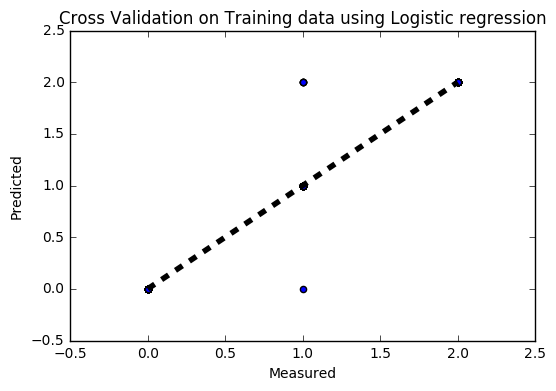

In [119]:
predictions = cross_val_predict(log_clf, X_train,y_train, cv=10)
fig, ax = plt.subplots()
ax.scatter(y_train, predictions)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Cross Validation on Training data using Logistic regression')
plt.show()

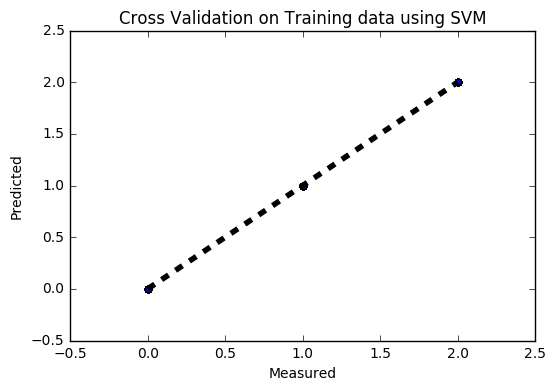

In [120]:
predictions = cross_val_predict(svm_clf, X_train,y_train, cv=10)
fig, ax = plt.subplots()
ax.scatter(y_train, predictions)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Cross Validation on Training data using SVM')
plt.show()

Confusion matrix, without normalization
[[455   0   0]
 [  1 440   2]
 [  0   0 774]]
Normalized confusion matrix
[[ 1.    0.    0.  ]
 [ 0.    0.99  0.  ]
 [ 0.    0.    1.  ]]


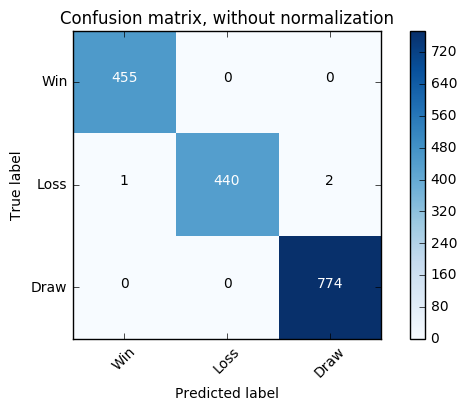

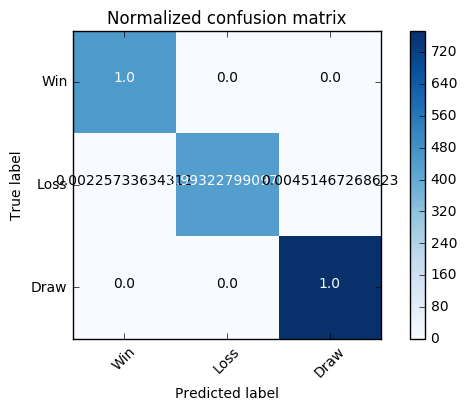

In [126]:

class_names = ['Win', 'Loss', 'Draw']
y_pred = log_clf.fit(X_train, y_train).predict(X_test)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# Testing the Current Data

In [130]:
testframe = pd.read_csv('epl1617.csv')
col = ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'Referee', 'HST', 'AST', 'HC', 'AC', 'HR', 'AR']
testframe = testframe[col]
#testframe = pd.concat(df_temp) 
testframe.loc[testframe['FTR'] == 'A','FTR'] = 0
testframe.loc[testframe['FTR'] == 'D','FTR'] = 1
testframe.loc[testframe['FTR'] == 'H','FTR'] = 2
testframe['FTR'] = testframe['FTR'].apply(lambda x:float(x))
#testframe = dataframe.dropna()

In [131]:
testframe

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Referee,HST,AST,HC,AC,HR,AR
0,13/08/16,Burnley,Swansea,0,1,0.0,J Moss,3,9,7,4,0,0
1,13/08/16,Crystal Palace,West Brom,0,1,0.0,C Pawson,4,3,3,6,0,0
2,13/08/16,Everton,Tottenham,1,1,1.0,M Atkinson,6,4,5,6,0,0
3,13/08/16,Hull,Leicester,2,1,2.0,M Dean,5,5,5,3,0,0
4,13/08/16,Man City,Sunderland,2,1,2.0,R Madley,4,3,9,6,0,0
5,13/08/16,Middlesbrough,Stoke,1,1,1.0,K Friend,2,1,9,6,0,0
6,13/08/16,Southampton,Watford,1,1,1.0,R East,6,1,6,2,0,1
7,14/08/16,Arsenal,Liverpool,3,4,0.0,M Oliver,5,7,5,4,0,0
8,14/08/16,Bournemouth,Man United,1,3,0.0,A Marriner,3,7,4,2,0,0
9,15/08/16,Chelsea,West Ham,2,1,2.0,A Taylor,6,3,7,1,0,0


In [132]:
testcolumns = testframe.columns.tolist()
testcolumns = [c for c in columns if c not in ['Date', 'HomeTeam', 'AwayTeam', 'Referee']]
testtarget = 'FTR'

In [133]:
_6HW = []
_6HL = []
_6AW = []
_6AL = []
_6FTHGS = []
_6FTHGC = []
_6FTAGS = []
_6FTAGC = []
_6HST = []
_6AST = []
_6HC = []
_6AC = []
_6HR = []
_6AR = []
_H2H6FTHGS = []
_H2H6FTAGS = []
_H2H6FTHGC = []
_H2H6FTAGC = []
_H2H6HST = []
_H2H6AST = []
_H2H6HC = []
_H2H6AC = []
_H2H6HR = []
_H2H6AR = []
_6HD = []
_6AD = []

# building the final data frame
for _,row in testframe.iterrows():
    _6HW.append(get_number_of_wins(dataframe, str(row['Date']), str(row['HomeTeam'])))
    _6AW.append(get_number_of_wins(dataframe, str(row['Date']), str(row['AwayTeam'])))
    _6HD.append(get_number_of_draws(dataframe, str(row['Date']), str(row['HomeTeam'])))
    _6AD.append(get_number_of_draws(dataframe, str(row['Date']), str(row['AwayTeam'])))
    _6HL.append(get_number_of_losses(dataframe, str(row['Date']), str(row['HomeTeam'])))
    _6AL.append(get_number_of_losses(dataframe, str(row['Date']), str(row['AwayTeam'])))
    _6FTHGS.append(get_number_of_goals_scored(dataframe, str(row['Date']), str(row['HomeTeam'])))
    _6FTHGC.append(get_number_of_goals_conceded(dataframe, str(row['Date']), str(row['HomeTeam'])))
    _6FTAGS.append(get_number_of_goals_scored(dataframe, str(row['Date']), str(row['AwayTeam'])))
    _6FTAGC.append(get_number_of_goals_conceded(dataframe, str(row['Date']), str(row['AwayTeam'])))
    _6HST.append(get_number_of_shots_on_target(dataframe, str(row['Date']), str(row['HomeTeam'])))
    _6AST.append(get_number_of_shots_on_target(dataframe, str(row['Date']), str(row['AwayTeam'])))
    _6HC.append(get_number_of_corners(dataframe, str(row['Date']), str(row['HomeTeam'])))
    _6AC.append(get_number_of_corners(dataframe, str(row['Date']), str(row['AwayTeam'])))
    _6HR.append(get_number_of_red_cards(dataframe, str(row['Date']), str(row['HomeTeam'])))
    _6AR.append(get_number_of_red_cards(dataframe, str(row['Date']), str(row['AwayTeam'])))
    _H2H6FTHGS.append(get_number_of_h2h_home_goals_scored(dataframe, str(row['Date']), str(row['HomeTeam']), str(row['AwayTeam']), str(row['HomeTeam'])))
    _H2H6FTAGS.append(get_number_of_h2h_away_goals_scored(dataframe, str(row['Date']), str(row['HomeTeam']), str(row['AwayTeam']), str(row['AwayTeam'])))
    _H2H6FTHGC.append(get_number_of_h2h_home_goals_conceded(dataframe, str(row['Date']), str(row['HomeTeam']), str(row['AwayTeam']), str(row['HomeTeam'])))
    _H2H6FTAGC.append(get_number_of_h2h_away_goals_conceded(dataframe, str(row['Date']), str(row['HomeTeam']), str(row['AwayTeam']), str(row['AwayTeam'])))
    _H2H6HST.append(get_number_of_h2h_home_shot_on_target(dataframe, str(row['Date']), str(row['HomeTeam']), str(row['AwayTeam']), str(row['HomeTeam'])))
    _H2H6AST.append(get_number_of_h2h_away_shot_on_target(dataframe, str(row['Date']), str(row['HomeTeam']), str(row['AwayTeam']), str(row['AwayTeam'])))
    _H2H6HC.append(get_number_of_h2h_home_corners(dataframe, str(row['Date']), str(row['HomeTeam']), str(row['AwayTeam']), str(row['HomeTeam'])))
    _H2H6AC.append(get_number_of_h2h_away_corners(dataframe, str(row['Date']), str(row['HomeTeam']), str(row['AwayTeam']), str(row['AwayTeam'])))
    _H2H6HR.append(get_number_of_h2h_home_red_cards(dataframe, str(row['Date']), str(row['HomeTeam']), str(row['AwayTeam']), str(row['HomeTeam'])))
    _H2H6AR.append(get_number_of_h2h_away_red_cards(dataframe, str(row['Date']), str(row['HomeTeam']), str(row['AwayTeam']), str(row['AwayTeam'])))
testframe['6HW'] = _6HW
testframe['6AW'] = _6AW
testframe['6HD'] = _6HD
testframe['6AD'] = _6AD
testframe['6HL'] = _6HL
testframe['6AL'] = _6AL
testframe['6FTHGS'] = _6FTHGS
testframe['6FTHGC'] = _6FTHGC
testframe['6FTAGS'] = _6FTAGS
testframe['6FTAGC'] = _6FTAGC
testframe['6HST']=_6HST
testframe['6AST']=_6AST
testframe['6HC']=_6HC
testframe['6AC']=_6AC
testframe['6HR'] = _6HR
testframe['6AR']=_6AR
testframe['H2H6FTHGS']=_H2H6FTHGS
testframe['H2H6FTAGS']=_H2H6FTAGS
testframe['H2H6FTHGC']=_H2H6FTHGC
testframe['H2H6FTAGC']=_H2H6FTAGC
testframe['H2H6HST']=_H2H6HST
testframe['H2H6AST']=_H2H6AST
testframe['H2H6HC']=_H2H6HC
testframe['H2H6AC']=_H2H6AC
testframe['H2H6HR']=_H2H6HR
testframe['H2H6AR']=_H2H6AR

In [134]:
testframe.shape

(150, 39)

In [140]:
testframe.dropna()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Referee,HST,AST,HC,...,H2H6FTHGS,H2H6FTAGS,H2H6FTHGC,H2H6FTAGC,H2H6HST,H2H6AST,H2H6HC,H2H6AC,H2H6HR,H2H6AR
0,13/08/16,Burnley,Swansea,0,1,0.0,J Moss,3,9,7,...,0.0,1.0,1.0,0.0,6.0,2.0,6.0,4.0,0.0,0.0
1,13/08/16,Crystal Palace,West Brom,0,1,0.0,C Pawson,4,3,3,...,5.0,3.0,3.0,5.0,18.0,12.0,19.0,16.0,0.0,0.0
2,13/08/16,Everton,Tottenham,1,1,1.0,M Atkinson,6,4,5,...,1.0,2.0,2.0,1.0,5.0,13.0,14.0,13.0,0.0,0.0
3,13/08/16,Hull,Leicester,2,1,2.0,M Dean,5,5,5,...,0.0,1.0,1.0,0.0,5.0,2.0,7.0,1.0,1.0,1.0
4,13/08/16,Man City,Sunderland,2,1,2.0,R Madley,4,3,9,...,9.0,5.0,5.0,9.0,25.0,10.0,18.0,11.0,0.0,0.0
5,13/08/16,Middlesbrough,Stoke,1,1,1.0,K Friend,2,1,9,...,2.0,1.0,1.0,2.0,12.0,2.0,4.0,5.0,0.0,1.0
6,13/08/16,Southampton,Watford,1,1,1.0,R East,6,1,6,...,2.0,0.0,0.0,2.0,7.0,1.0,8.0,1.0,0.0,0.0
7,14/08/16,Arsenal,Liverpool,3,4,0.0,M Oliver,5,7,5,...,6.0,1.0,1.0,6.0,22.0,14.0,16.0,18.0,0.0,1.0
8,14/08/16,Bournemouth,Man United,1,3,0.0,A Marriner,3,7,4,...,2.0,1.0,1.0,2.0,5.0,5.0,5.0,7.0,0.0,0.0
9,15/08/16,Chelsea,West Ham,2,1,2.0,A Taylor,6,3,7,...,4.0,2.0,2.0,4.0,23.0,7.0,31.0,18.0,0.0,0.0


In [145]:
X_train = dataframe[columns]
y_train = dataframe[target]
X_test = testframe[columns] 
y_test = testframe[target]

In [146]:
print("\nNaive Bayes")
GNB_clf = GaussianNB()
GNB_clf.fit(X_train, y_train)
predictions = GNB_clf.predict(X_test)
print("accuracy on testing data")
accuracy_score(y_test,predictions)


Naive Bayes
accuracy on testing data


1.0

In [149]:
print("\nSVM Model")
svm_clf = SVC(kernel='linear', C=.01)
svm_clf.fit(X_train, y_train)
predictions = svm_clf.predict(X_test)
print("accuracy on testing data")
accuracy_score(y_test,predictions)


SVM Model
accuracy on testing data


1.0